In [1]:
%%markdown

# Sequential SuperLU Traces

The traces share the following properties: 

* CFD Problems
* 100% Pattern symmetry
* <100% Numeric symmetry
* Full rank

This trace is from `EXAMPLE/ditersol`, which ships with SuperLU. 
We have slightly modified it to accept matrices as command line arguments, 
as opposed to reading them off of `stdin`. 




# Sequential SuperLU Traces

The traces share the following properties: 

* CFD Problems
* 100% Pattern symmetry
* <100% Numeric symmetry
* Full rank

This trace is from `EXAMPLE/ditersol`, which ships with SuperLU. 
We have slightly modified it to accept matrices as command line arguments, 
as opposed to reading them off of `stdin`. 



In [1]:
import sveCacheSim as sim
import CacheModels
import matplotlib.pyplot as plt
import numpy as nppace
import pandas as pd
import pickle
from tqdm import tqdm
import importlib
importlib.reload(sim)
pass
import os

In [2]:
os.chdir('/storage/home/hhive1/plavin3/data/ModelSwapping')
slu = {}

## Choose a group of runs
#GROUP='slu'
GROUP='parsec'

traces_slu = ['steam1', 'steam2', 'orsirr_1', 'orsirr_2', 'orsreg_1']
traces_parsec = ['blackscholes', 'bodytrack', 'ferret', 'fluidanimate', 'freqmine']
models = ['BASE', 'FR', 'M4', 'M8', 'ALL']

if GROUP =='slu':
    traces = traces_slu
elif GROUP == 'parsec':
    traces = traces_parsec
else:
    raise ValueError()
    
for tr in traces:
    slu[tr] = {}
    for mo in models:
        if GROUP == 'slu':
            filename = 'DataV4/slu_{}-{}-data.pkl'.format(tr, mo)
        elif GROUP=='parsec':
            filename = 'DataV4/{}-{}-data.pkl'.format(tr, mo)
            
        try:
            slu[tr][mo] = sim.load_object(filename)


            
        except:
            print('Failed to load {}'.format(filename))



In [9]:
%%markdown

### Phase Trace Object
We first need to grab the phase trace object from the stats of our simulation. It is stored in `stats_*.phase_trace`. This object
has type `PhaseTrace` which is defined in `PhaseDetector.py` and includes 4 fields.

* `trace`: The phase assigned to each interval. -1 represents an interval not identified as part of a phase. 
* `nphases`: The number of unique phases identified.
* `phase_count`: A list of length nphases where phase_count[i] is the number of intervals assigned to phase i
* `phase_unique`: A list of length nphases where phase_unique[i] is the number of times phase i was entered

Let's take a look at these for the 'large' trace. 


### Phase Trace Object
We first need to grab the phase trace object from the stats of our simulation. It is stored in `stats_*.phase_trace`. This object
has type `PhaseTrace` which is defined in `PhaseDetector.py` and includes 4 fields.

* `trace`: The phase assigned to each interval. -1 represents an interval not identified as part of a phase. 
* `nphases`: The number of unique phases identified.
* `phase_count`: A list of length nphases where phase_count[i] is the number of intervals assigned to phase i
* `phase_unique`: A list of length nphases where phase_unique[i] is the number of times phase i was entered

Let's take a look at these for the 'large' trace. 


In [17]:
def phase_summary(name, trace):
    tr = trace.phase_trace
    print(name, ':')
    print('  Identified', tr.nphases, 'phases')
    print('  Number of intervals assigned to each phase', tr.phase_count)
    #print('  Number of times each phase was entered', tr.phase_unique)
    
for tr in slu.keys():
    if 'BASE' in slu[tr].keys():
        phase_summary(tr, slu[tr]['BASE'])

blackscholes :
  Identified 1 phases
  Number of intervals assigned to each phase [24]
bodytrack :
  Identified 20 phases
  Number of intervals assigned to each phase [33, 347, 5, 227, 1217, 2434, 2184, 2176, 15, 24, 14, 30, 605, 604, 83, 56, 57, 56, 7, 21]
ferret :
  Identified 22 phases
  Number of intervals assigned to each phase [129, 233, 224, 42, 43, 91, 33, 72, 300, 48, 31, 167, 75, 116, 938, 90, 86, 191, 72, 16, 188, 2]
fluidanimate :
  Identified 11 phases
  Number of intervals assigned to each phase [33, 1106, 12, 63, 15, 2544, 3981, 93, 64, 63, 1133]
freqmine :
  Identified 17 phases
  Number of intervals assigned to each phase [32, 140, 126, 35, 2, 1, 47, 46, 6, 96, 312, 4, 8, 4, 14, 185, 141]


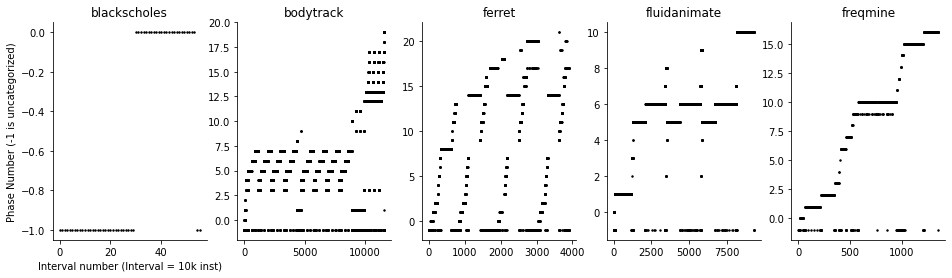

In [4]:
def plot_trace(ax, label, trace, axis_labels):
    ax.scatter([*range(len(trace))], trace,s=2, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(label)
    if axis_labels:
        ax.set_ylabel('Phase Number (-1 is uncategorized)')
        ax.set_xlabel('Interval number (Interval = 10k inst)')

fig, ax = plt.subplots(1, len(slu.keys()), figsize=(16,4))
for idx, tr in enumerate(slu.keys()):
    if 'BASE' in slu[tr].keys():
        plot_trace(ax[idx], tr,  slu[tr]['BASE'].phase_trace.trace,  idx == 0)
#plt.savefig('plots/phase-traces.svg')
plt.show()

In [3]:
def get_acc(st1, st2, phase):
    # t1 is assumed to be from the base cache
    
    t1 = st1.cache_trace[0] # cache trace from st1
    t2 = st2.cache_trace[0] # cache trace from st2
    
    # Just get accesses where were are in phase `phase` and in state is Swapped (2)
    pick_state = t2['state'] == 2
    pick_phase = t2['phase'] == phase
    
    pick = np.logical_and(pick_state, pick_phase)
    
    # Get the hit/miss from each 
    t1_hits = t1['isHit'][pick]
    t2_hits = t2['isHit'][pick]
    
    num_correct = np.sum(np.equal(t1_hits, t2_hits))
    acc = num_correct / len(t1_hits)
    
    return acc
    
    
def get_stats(stats):
    nphases = stats['BASE'].phase_trace.nphases
    name_map={'FR':'Fixed Rate', 'M4': 'Markov 4', 'M8':'Markov 8', 'ALL':'All'}
    data = {}
    for name in stats:
        if name is 'BASE':
            continue
        acc = []
        for i in range(nphases):
            acc.append(get_acc(stats['BASE'], stats[name], i))
        data[name_map[name]] = acc
    return pd.DataFrame(data)
acc = {}
for tr in slu.keys():
    if 'BASE' in slu[tr].keys():
        print('{} Accuracy'.format(tr))
        acc[tr] = get_stats(slu[tr])
        print(acc[tr])
        print()




blackscholes Accuracy
   Fixed Rate  Markov 4  Markov 8       All
0    0.716759  0.729032  0.758609  0.758491

bodytrack Accuracy
    Fixed Rate  Markov 4  Markov 8       All
0     0.607297  0.622994  0.699826  0.700290
1     0.751069  0.752088  0.789465  0.790097
2     0.626709  0.766467  0.796967  0.793333
3     0.985080  0.624175  0.714450  0.713941
4     0.625822  0.984446  0.983992  0.985062
5     0.983805  0.627209  0.667981  0.667693
6     0.828115  0.983568  0.983672  0.983819
7     0.654131  0.830630  0.830548  0.828175
8     0.802577  0.665862  0.722054  0.720269
9     0.802896  0.815927  0.825582  0.814968
10    0.650708  0.665625  0.722067  0.720249
11    0.641686  0.661354  0.722071  0.971615
12    0.971744  0.971502  0.978004  0.948579
13    0.948729  0.952262  0.954219  0.931777
14    0.931444  0.933269  0.935148  0.938414
15    0.879914  0.937922  0.938287  0.932109
16    0.875540  0.932765  0.932191  0.915143
17    0.869915  0.915181  0.916935  0.500480
18    0.502780 

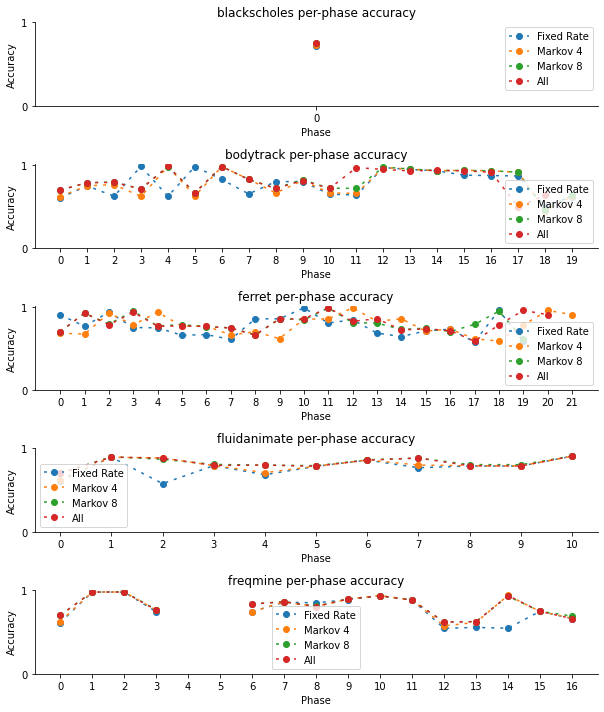

In [5]:
nn=1

def acc_plot(ax, acc, slu, tr):
    df = acc[tr]
    ny = slu[tr]['BASE'].phase_trace.nphases
    #ax=plt.gca()
    df.plot(xticks=[*range(0,ny,1)],
            yticks=[i/nn for i in range(0,nn+1)], 
                 title='{} per-phase accuracy'.format(tr),ax=ax, 
                 marker='o', linestyle=(0, (2,4)))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Phase')
    #ax.get_legend().remove()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    cmap = plt.get_cmap("tab10")
    #ax.text( x=ny-1+.1, y=df['Fixed Rate'][ny-1], s='Fixed Rate', color=cmap(0))
    #ax.text( x=4.1, y=df['Markov 4'][ny-1], s='Markov 4', color=cmap(1))
    #ax.text( x=4.1, y=df['Markov 8'][ny-1], s='Markov 8', color=cmap(2))
    plt.tight_layout()

fig, ax = plt.subplots(len(slu.keys()), 1, figsize=(8.5,10))
for idx, tr in enumerate(slu.keys()):
    if 'BASE' in slu[tr].keys():
        acc_plot(ax[idx], acc, slu, tr)
    #acc_plot(acc, slu, 'steam2')
#plt.savefig('plots/per-phase-accuracy.svg')

blackscholes
bodytrack
ferret
fluidanimate
freqmine


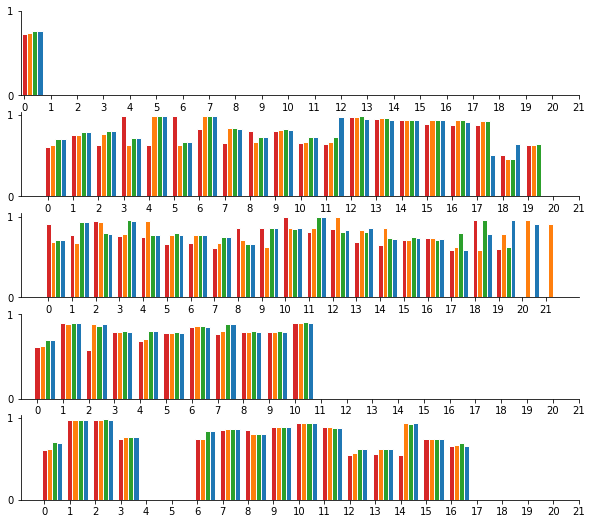

In [7]:
nn=1
maxidx=len(slu.keys())
barwidth=.2

colors = plt.cm.get_cmap('tab10').colors
colormap={'All': colors[0], 'Markov 4':colors[1], 'Markov 8':colors[2], 'Fixed Rate':colors[3]}


def acc_plot(ax, acc, slu, tr, idx):
    df = acc[tr]
    ny = slu[tr]['BASE'].phase_trace.nphases
    #ax=plt.gca()
    print(tr)
    for idx,k in enumerate(acc[tr]):
        bars=acc[tr][k]
        r = np.arange(len(bars)) + barwidth*idx
        ax.bar(r, bars, color=colormap[k], width=barwidth, edgecolor='white', label='var1')

    #ax.xticks([r + barwidth for r in range(len(bars))], ['A', 'B', 'C', 'D'])
    ax.set_yticks([0,1])
    ax.set_xticks([*range(0,22,1)])
    

    
    #df.plot(xticks=[*range(0,ny,1)],
    #        yticks=[i/nn for i in range(0,nn+1)], 
    #             title='{}'.format(tr),ax=ax, 
    #             marker='o', linestyle=(0, (2,4)))
    #if idx == maxidx - 1:
    #    ax.set_ylabel('Accuracy')
    #    ax.set_xlabel('Phase')

    #ax.get_legend().remove()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #cmap = plt.get_cmap("tab10")

    #plt.tight_layout()

fig, ax = plt.subplots(len(slu.keys()), 1, figsize=(10,9))
for idx, tr in enumerate(slu.keys()):
    if 'BASE' in slu[tr].keys():
        acc_plot(ax[idx], acc, slu, tr, idx)
    #acc_plot(acc, slu, 'steam2')
#plt.savefig('plots/per-phase-accuracy.svg')

In [94]:
%%markdown

## Accuracy Over Time
Let's now take a look at how accuracy changes over the course of a simulation. Does it get worse over time? 

As we're using the small trace, we won't see much here. Please re-run the notebook to get a better large chart. 

The reason a legend isn't generated is because it is hard to place it well. To get a legend, re-run the plot and uncomment the line labeled as such. 
Then grab the legend and paste it onto the plot in a good area. 


## Accuracy Over Time
Let's now take a look at how accuracy changes over the course of a simulation. Does it get worse over time? 

As we're using the small trace, we won't see much here. Please re-run the notebook to get a better large chart. 

The reason a legend isn't generated is because it is hard to place it well. To get a legend, re-run the plot and uncomment the line labeled as such. 
Then grab the legend and paste it onto the plot in a good area. 


In [92]:
interval_len = 10000
def acc_over_time(st1, st2, phase):
    
    t1 = st1.cache_trace[0] # cache trace from st1
    t2 = st2.cache_trace[0] # cache trace from st2
    
    # Just get accesses where were are in phase `phase` and in state is Swapped (2)
    pick_state = t2['state'] == 2
    pick_phase = t2['phase'] == phase
    
    pick = np.logical_and(pick_state, pick_phase)
    
    # Get the hit/miss from each 
    t1_hits = t1['isHit'][pick]
    t2_hits = t2['isHit'][pick]
    
    nintervals = int(len(t1_hits) // interval_len)-1
    
    acc = []
    
    for i in range(nintervals):
        start = i*interval_len
        end   = (i+1)*interval_len
        t1_hits_rest = t1_hits[start:end]
        t2_hits_rest = t2_hits[start:end]
    
        num_correct = np.sum(np.equal(t1_hits_rest, t2_hits_rest))
        acc.append(num_correct / interval_len)
    
    return acc

nphases = stats['base'].phase_trace.nphases
name_map={'fr':'Fixed Rate', 'm4': 'Markov 4', 'm8':'Markov 8', 'all':'All'}
all_df = {}
for i in range(nphases):
    data = {}
    for name in stats:
        if name is 'base':
            continue
        data[name_map[name]] = acc_over_time(stats['base'], stats[name], i)
    data_df = pd.DataFrame(data)    
    all_df[i] = data_df


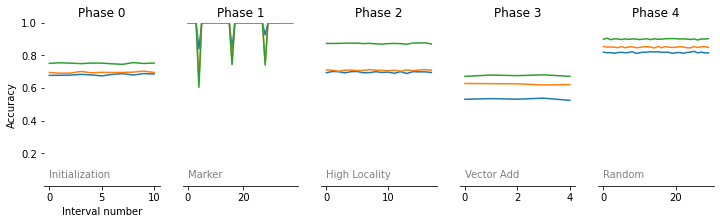

In [120]:
pretty=['Initialization', 'Marker', 'High Locality', 'Vector Add', 'Random']
def acc_over_time_plot(ax, approx, m4, m8, phase):
    ax.plot(approx, label='Fixed Rate')
    ax.plot(m4, label='Markov 4')
    ax.plot(m8, label='Markov 8')    
    ax.set_ylim((0,1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_ticks([])
    ax.set_title('Phase {}'.format(phase))
    ax.text(x=0, y=.05, s=pretty[phase], color='grey')
    if phase == 0:
        ax.set_ylabel('Accuracy')
        ax.get_yaxis().set_ticks([.2, .4, .6, .8, 1.])
        ax.set_xlabel('Interval number')
    if phase == 4:
        pass
        #ax.legend(loc=10) ##UNCOMMENT ME FOR LEGEND

fig, ax = plt.subplots(1, 5, figsize=(12,3), squeeze=False)
for phase in range(5):    
    acc_over_time_plot(ax[0,phase], 
          all_df[phase]['Fixed Rate'],
          all_df[phase]['Markov 4'],
          all_df[phase]['Markov 8'],
          phase)
#plt.savefig('plots/acc-over-time.svg')
plt.show()


In [95]:
%%markdown

## Accuracy as a function of Model Size

This is just a fun little plot. 


## Accuracy as a function of Model Size

This is just a fun little plot. 


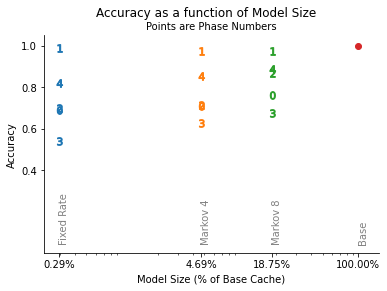

In [121]:
bs=8192
sz = {'base':1, 'fr':24/bs, 'm4':(3 * (4 * 4) * 8)/bs, 'm8':(3 * (8 * 8) * 8)/bs}

fig, ax = plt.subplots()
cmap = plt.get_cmap("tab10")
for i in range(5):
    ax.scatter([sz['fr']], accuracy_df['Fixed Rate'][i], marker='${}$'.format(i), color=cmap(0), s=60)
for i in range(5):
    ax.scatter([sz['m4']], accuracy_df['Markov 4'][i], marker='${}$'.format(i), color=cmap(1), s=60)
for i in range(5):
    ax.scatter([sz['m8']], accuracy_df['Markov 8'][i], marker='${}$'.format(i), color=cmap(2), s=60)
ax.scatter(1,1,  color=cmap(3))
ax.set_xscale('log')


labs=np.float64([24/bs, (3 * (4 * 4) * 8)/bs, (3 * (8 * 8) * 8)/bs, 1])*100
ax.get_xaxis().set_ticks([24/bs, (3 * (4 * 4) * 8)/bs, (3 * (8 * 8) * 8)/bs, 1])
ax.set_xticklabels(['{:.2f}%'.format(labs[i]) for i in range(4)])

ax.get_yaxis().set_ticks([.4,.6, .8, 1])

ax.set_xlabel('Model Size (% of Base Cache)')
ax.set_ylabel('Accuracy')
ax.set_ylim(0,1.05)
ax.set_xlim(0,1.5)
ax.text(x=labs[0]/100, y=.05, s='Fixed Rate', rotation=90, color='grey')
ax.text(x=labs[1]/100, y=.05, s='Markov 4', rotation=90, color='grey')
ax.text(x=labs[2]/100, y=.05, s='Markov 8', rotation=90, color='grey')
ax.text(x=labs[3]/100, y=.05, s='Base', rotation=90, color='grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Points are Phase Numbers', size=10)
fig.suptitle('Accuracy as a function of Model Size')

#plt.savefig('plots/acc_vs_modelsize.svg')

plt.show()

In [101]:
%%markdown

## Locality Analysis

Finally, we get to the hardest plot to generate, the locality plot. 


## Locality Analysis

Finally, we get to the hardest plot to generate, the locality plot. 


In [111]:
def index(array, item):
    for idx, val in enumerate(array):
        if val == item:
            return idx
    return -1

def rightshift(val: np.uint64, shift: np.uint64) -> np.uint64:
    return val >> shift

def reuse(trace, shift, outfile=None):
    stack = np.array([], dtype=np.int64)
    out = []
    for i in tqdm(range(len(trace))):
        addr = rightshift(trace[i], np.uint64(shift)) # Cache line
        idx = index(stack, addr)
        if idx == -1:
            stack = np.insert(stack, 0, addr)
        else:
            out.append(idx)
            stack = np.delete(stack, idx)
            stack = np.insert(stack, 0, addr)

    if outfile is not None:
        save_object(out, outfile)
        print('Wrote reuse trace to: {}'.format(outfile))
        
    return out


In [113]:
reuse_perphase_base    = {}
reuse_perphase_approx  = {}
reuse_perphase_markov4 = {}
reuse_perphase_markov8 = {}
gran=6

def get_addrs(data, phase):
    df = pd.DataFrame(data)
    return np.array(df[df['phase']==phase]['addr'], dtype=np.uint64)

for phase in range(0,5):
    reuse_perphase_base[phase] = reuse(get_addrs(stats['base'].cache_trace[1], phase), gran)
    reuse_perphase_approx[phase] = reuse(get_addrs(stats['fr'].cache_trace[1], phase), gran)
    reuse_perphase_markov4[phase] = reuse(get_addrs(stats['m4'].cache_trace[1], phase), gran)
    reuse_perphase_markov8[phase] = reuse(get_addrs(stats['m8'].cache_trace[1], phase), gran)

100%|██████████| 4826/4826 [00:02<00:00, 2337.25it/s]
0it [00:00, ?it/s]
100%|██████████| 36357/36357 [00:02<00:00, 17691.74it/s]


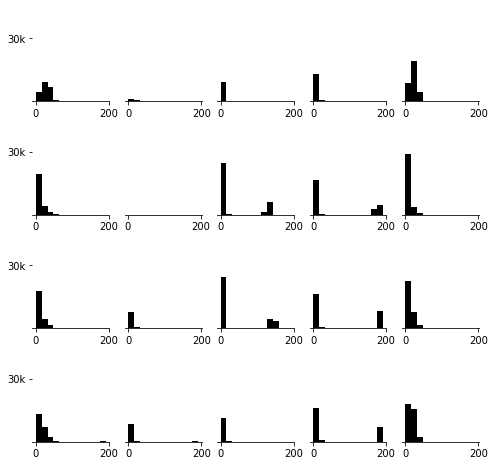

In [123]:
binwidth=16
#maxbin={1:50, 2:850, 3:225, 4:50}
maxbin={0:200,1:200, 2:200, 3:200, 4:200}

yl=45000
ylim={0:yl,1:yl, 2:yl, 3:yl, 4:yl}


def bins(data, binwidth, maxbin):
    #return range(min(data), min(maxbin, max(data) + binwidth), binwidth)
   # print(data)
    return range(min(data), maxbin, binwidth)

def plot(ax, data, title, phase):
    if not data:
        data = [1]
    ax.hist(data, bins=bins(data, binwidth, maxbin=maxbin[phase]), color='black')
    ax.set_ylim((0,ylim[phase]))
    #ax.suptitle(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_ticks([])
    if phase == 0:
        ax.get_yaxis().set_ticks([30000])
        ax.set_yticklabels(['30k'])
    
#plot(reuse_perphase_base[1], 'Base Cache', maxbin=maxbin[1])
#plot(reuse_perphase_approx[1], 'Fixed Rate Cache', maxbin=maxbin[1])
#plot(reuse_perphase_markov4[1], '4-State Markov Cache', maxbin=maxbin[1])
#plot(reuse_perphase_markov8[1], '8-State Markov Cache', maxbin=maxbin[1])

#i = 1

fig, ax = plt.subplots(4, 5, figsize=(8,8))
for i in range(5):
    #phase = i+1
    phase=i
    
    plot(ax[0,i], reuse_perphase_base[phase], 'Base Cache', phase)
    plot(ax[1,i], reuse_perphase_approx[phase], 'Fixed Rate Cache', phase)
    plot(ax[2,i], reuse_perphase_markov4[phase], '4-State Markov Cache', phase)
    plot(ax[3,i], reuse_perphase_markov8[phase], '8-State Markov Cache', phase)

#plt.savefig('plots/locality_per_phase.svg')
plt.show()